# Transit Light Curve analysis
We shall use a package called eleanor to extract light curve from TESS
See https://adina.feinste.in/eleanor/index.html for more information about the Eleanor package
+  "TESS Full Frame Images (FFIs) to extracted and systematics-corrected light curves for any given star observed by TESS"


In [1]:
import eleanor
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'eleanor'

## Get WASP-100's light curve from TESS data

In [ ]:
# Based on https://adina.feinste.in/eleanor/#idocs_quickstart
star = eleanor.Source(name='WASP-100', sector=1)
print('Found TIC {0} (Gaia {1}), with TESS magnitude {2}, RA {3}, and Dec {4}'
     .format(star.tic, star.gaia, star.tess_mag, star.coords[0], star.coords[1]))

INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_bkg.fits with expected size 78955200. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc.fits with expected size 158022720. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0001-4-1_tess_v2_pm.txt with expected size 237847. [astroquery.query]
Found TIC 38846515 (Gaia 4675352109659600000), with TESS magnitude 10.3157, RA 68.95970874999999, and Dec -64.02703694444445


In [ ]:
# Do photometry to obtain the light curve
data = eleanor.TargetData(star, height=15, width=15, bkg_size=31, do_psf=False, do_pca=True, regressors='corner')

<IPython.core.display.Javascript object>


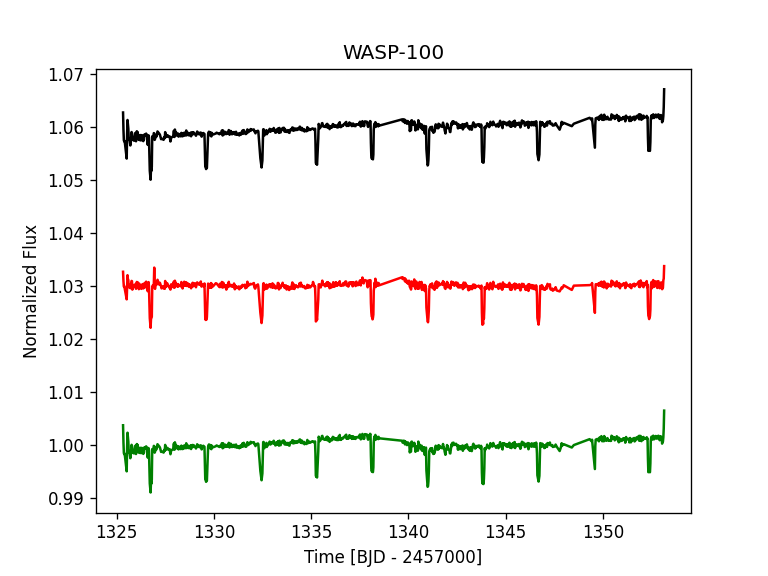

In [ ]:
%matplotlib notebook
#plt.figure(figsize=(15,5))

q = data.quality == 0

plt.plot(data.time[q], data.raw_flux[q]/np.nanmedian(data.raw_flux[q])+0.06, 'k')
plt.plot(data.time[q], data.corr_flux[q]/np.nanmedian(data.corr_flux[q]) + 0.03, 'r')
plt.plot(data.time[q], data.pca_flux[q]/np.nanmedian(data.pca_flux[q]), 'g')
#plt.plot(data.time[q], data.psf_flux[q]/np.nanmedian(data.psf_flux[q]) - 0.02, 'b')
plt.ylabel('Normalized Flux')
plt.xlabel('Time [BJD - 2457000]')
plt.title('WASP-100');

## BoxLeastSquares to find period and transists
+ See https://docs.astropy.org/en/latest/timeseries/bls.html on BLS

<IPython.core.display.Javascript object>


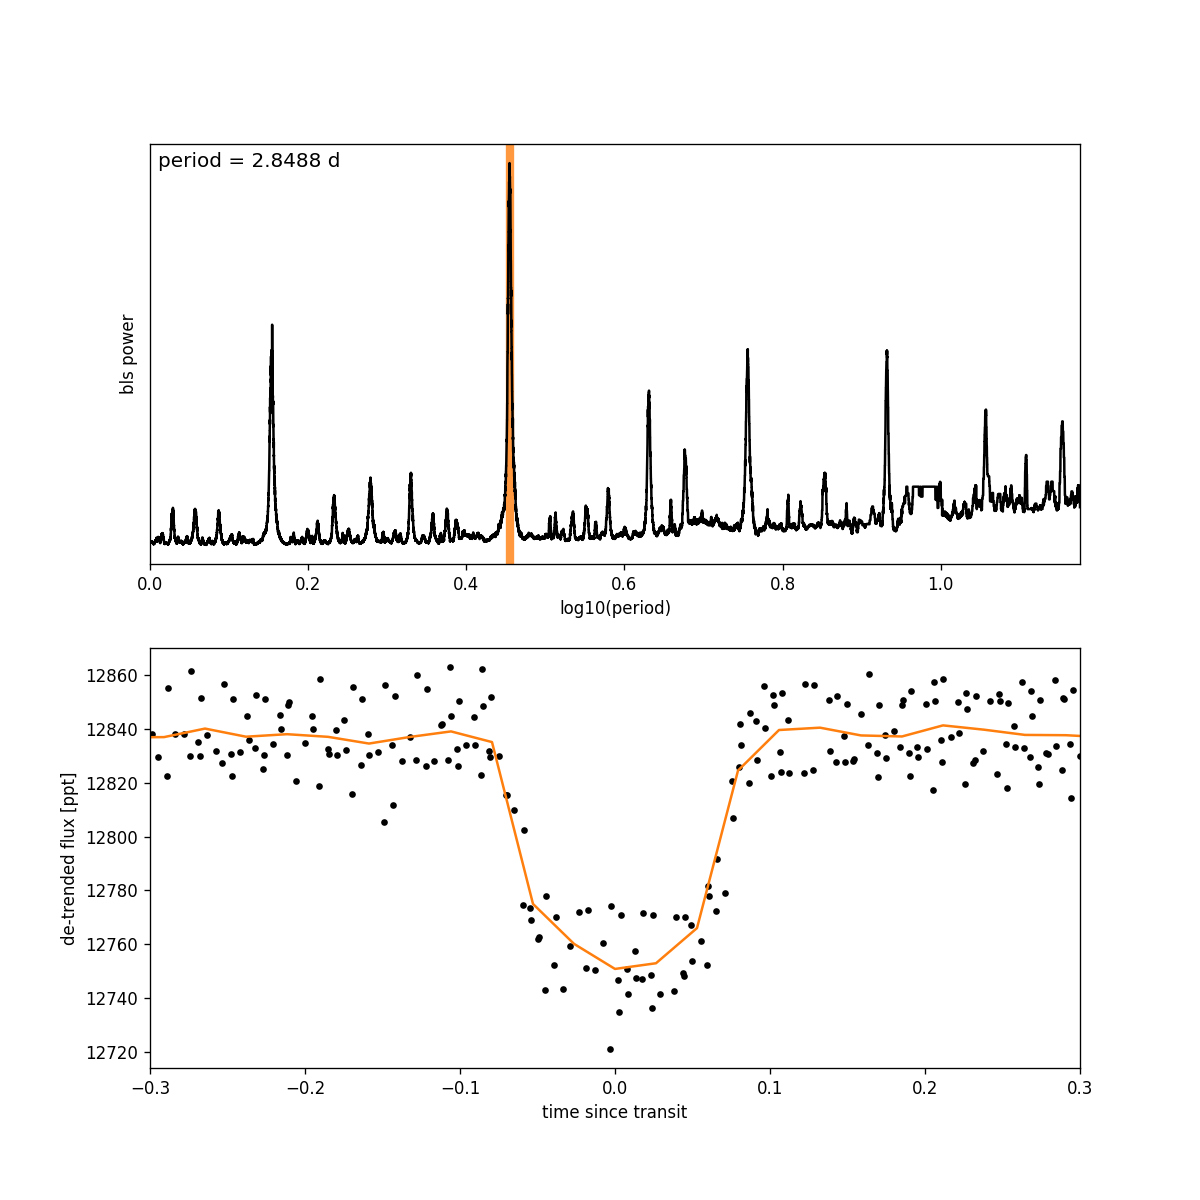

In [ ]:
# Based on https://docs.exoplanet.codes/en/v0.2.1/tutorials/tess/
# See https://docs.astropy.org/en/latest/timeseries/bls.html on BLS

from astropy.timeseries import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(data.time[q], data.pca_flux[q])
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(data.time[q], bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate("period = {0:.4f} d".format(bls_period),
            (0, 1), xycoords="axes fraction",
            xytext=(5, -5), textcoords="offset points",
            va="top", ha="left", fontsize=12)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (data.time[q] - bls_t0 + 0.5*bls_period)%bls_period - 0.5*bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold[m], data.pca_flux[q][m], ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=data.pca_flux[q])
denom[num == 0] = 1.0
ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
ax.set_xlabel("time since transit");
plt.show()

## Let's create some artifical tranist light curves first

In [ ]:
from pytransit import QuadraticModel
times = np.linspace(0.85, 1.15,  100)
tm = QuadraticModel()
tm.set_data(times)
k = 0.1 # k is the planet-star radius ratio
ldc = [0, 0]#0.3 .1# ldc is an ndarray containing the model-specific limb darkening coefficients 
t0 = 1 # t0 is the zero epoch
p = 2.1 # p is the orbital period
a = 3.2 # a is the scaled semi-major axis in uunits of stellar radius
i = 0.45*np.pi # i is the inclination
e = 0 #e is the eccentricity
w = 0 #w is the argument of periastron
flux = tm.evaluate(k, ldc, t0, p, a, i, e, w)

ImportError: Numba needs NumPy 1.22 or less

In [ ]:
plt.plot(times,flux)
plt.show()


## Explore various parameter tweaks and its impact on the light curve

In [ ]:
k = 0.1 # k is the planet-star radius ratio
ldc = [0, 0]#0.3 .1# ldc is an ndarray containing the model-specific limb darkening coefficients 
t0 = 1 # t0 is the zero epoch
p = 2.1 # p is the orbital period
a = 3.2 # a is the scaled semi-major axis in uunits of stellar radius
i = 0.45*np.pi # i is the inclination
e = 0 #e is the eccentricity
w = 0 #w is the argument of periastron
flux = tm.evaluate(k, ldc, t0, p, a, i, e, w)
plt.plot(times,flux)
plt.show()

In [ ]:
# Based on https://github.com/hpparvi/PyTransit/blob/master/notebooks/001_simple_broadband_parameter_estimation.ipynb
from pytransit import TransitAnalysis
ta = TransitAnalysis(name='WASP-100', passbands='TESS', times=0.5*(bins[1:] + bins[:-1]), fluxes=(num / denom)/np.median(num/denom))
ta.print_parameters(1)

In [ ]:
ta.optimize_global(niter=500, npop=100)


In [ ]:
ta.plot_light_curves(method='fit');


In [ ]:
ta.sample_mcmc(niter=2000, thin=20, repeats=3, save=False)

In [ ]:

ta.plot_light_curves(method='posterior');


In [ ]:
import corner
df = ta.posterior_samples()


corner(df.derived_parameters);


# Lightkurve
See http://docs.lightkurve.org/quickstart.html

+ It can be used to download any light curve or pixel image data from TESS and Kepler